In [11]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
import multiprocessing
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 10)
pylab.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


### model with the exogeous shock

In [5]:
def run(iRun):
    np.random.seed(iRun)
    # simulation and data collection
    simulationSteps = 500
    cMatrix = np.ones((100,100))*0.8
    np.fill_diagonal(cMatrix, 1)
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 20.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.2,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 10,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,          
                    # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = cMatrix,
                    liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                    shockSize = 0.02,                                          # size of the shock
                    shockDuration = [300, 305]) # duration of the shock
                    
    model.datacollector.collect(model)
    for _ in range(simulationSteps):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data

def multiRun(numberOfruns):
    # running the simulation in parallel
    cpuNum = 48
    results = []
    batchNum = 0
    while numberOfruns > 0:
        if numberOfruns > cpuNum:
            numberOfruns = numberOfruns - cpuNum
            with multiprocessing.Pool() as pool:
                # run the function in parallel on the input values
                results = results + pool.map(run, range(batchNum*cpuNum, (batchNum+1)*cpuNum))
            batchNum = batchNum + 1
        else:
            with multiprocessing.Pool() as pool:
                results = results + pool.map(run, range(batchNum*cpuNum, batchNum*cpuNum + numberOfruns))
            numberOfruns = 0
    return results

In [6]:
def defaultNumber(results):
    defaultCollection = []
    for iter in range(len(results)):
        m, a = results[iter]
        defaultCollection.append(a.xs(500, level="Step")["Default"].sum())
    return defaultCollection
defaultCollection = []

In [7]:
defaultCollection.append(defaultNumber(multiRun(500)))

In [8]:
def run(iRun):
    np.random.seed(iRun)
    # simulation and data collection
    simulationSteps = 500
    cMatrix = np.ones((100,100))*0.8
    np.fill_diagonal(cMatrix, 1)
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 20.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.4,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 10,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,          
                    # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = cMatrix,
                    liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                    shockSize = 0.05,                                          # size of the shock
                    shockDuration = [300, 310]) # duration of the shock
                    
    model.datacollector.collect(model)
    for _ in range(simulationSteps):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data

def multiRun(numberOfruns):
    # running the simulation in parallel
    cpuNum = 48
    results = []
    batchNum = 0
    while numberOfruns > 0:
        if numberOfruns > cpuNum:
            numberOfruns = numberOfruns - cpuNum
            with multiprocessing.Pool() as pool:
                # run the function in parallel on the input values
                results = results + pool.map(run, range(batchNum*cpuNum, (batchNum+1)*cpuNum))
            batchNum = batchNum + 1
        else:
            with multiprocessing.Pool() as pool:
                results = results + pool.map(run, range(batchNum*cpuNum, batchNum*cpuNum + numberOfruns))
            numberOfruns = 0
    return results

In [9]:
defaultCollection.append(defaultNumber(multiRun(500)))

Exception ignored in: <function _releaseLock at 0x7fb7265d48b0>
Traceback (most recent call last):
  File "/home/dli36/anaconda3/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
def run(iRun):
    np.random.seed(iRun)
    # simulation and data collection
    simulationSteps = 500
    cMatrix = np.ones((100,100))*0.8
    np.fill_diagonal(cMatrix, 1)
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 15.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.2,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 10,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,          
                    # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = cMatrix,
                    liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                    shockSize = 0.05,                                          # size of the shock
                    shockDuration = [300, 310]) # duration of the shock
                    
    model.datacollector.collect(model)
    for _ in range(simulationSteps):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data

def multiRun(numberOfruns):
    # running the simulation in parallel
    cpuNum = 48
    results = []
    batchNum = 0
    while numberOfruns > 0:
        if numberOfruns > cpuNum:
            numberOfruns = numberOfruns - cpuNum
            with multiprocessing.Pool() as pool:
                # run the function in parallel on the input values
                results = results + pool.map(run, range(batchNum*cpuNum, (batchNum+1)*cpuNum))
            batchNum = batchNum + 1
        else:
            with multiprocessing.Pool() as pool:
                results = results + pool.map(run, range(batchNum*cpuNum, batchNum*cpuNum + numberOfruns))
            numberOfruns = 0
    return results

In [ ]:
defaultCollection.append(defaultNumber(multiRun(500)))

In [ ]:
def run(iRun):
    np.random.seed(iRun)
    # simulation and data collection
    simulationSteps = 500
    cMatrix = np.ones((100,100))*0.4
    np.fill_diagonal(cMatrix, 1)
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 20.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.2,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 10,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,          
                    # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = cMatrix,
                    liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                    shockSize = 0.05,                                          # size of the shock
                    shockDuration = [300, 310])
    model.datacollector.collect(model)
    for _ in range(simulationSteps):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model_data, agent_data

def multiRun(numberOfruns):
    # running the simulation in parallel
    cpuNum = 48
    results = []
    batchNum = 0
    while numberOfruns > 0:
        if numberOfruns > cpuNum:
            numberOfruns = numberOfruns - cpuNum
            with multiprocessing.Pool() as pool:
                # run the function in parallel on the input values
                results = results + pool.map(run, range(batchNum*cpuNum, (batchNum+1)*cpuNum))
            batchNum = batchNum + 1
        else:
            with multiprocessing.Pool() as pool:
                results = results + pool.map(run, range(batchNum*cpuNum, batchNum*cpuNum + numberOfruns))
            numberOfruns = 0
    return results


In [ ]:
defaultCollection.append(defaultNumber(multiRun(500)))

In [1]:
import numpy as np
import pandas as pd
label = ["base", "highCapitalReserve", "lowLevarage", "lowCorrelation"]
defaultCollection = np.load("defaultCollection.npy")
print(pd.DataFrame(data = defaultCollection.T, columns = label).describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &         base &  highCapitalReserve &  lowLevarage &  lowCorrelation \\
\midrule
count &  1000.000000 &         1000.000000 &  1000.000000 &      1000.00000 \\
mean  &    19.020000 &           13.390000 &    13.155000 &        18.28600 \\
std   &    23.673826 &           18.717057 &    18.765903 &        14.53339 \\
min   &     0.000000 &            0.000000 &     0.000000 &         0.00000 \\
25\%   &     1.000000 &            1.000000 &     1.000000 &         7.00000 \\
50\%   &     9.000000 &            5.000000 &     4.000000 &        15.00000 \\
75\%   &    28.000000 &           18.000000 &    19.000000 &        26.00000 \\
max   &   100.000000 &           97.000000 &    98.000000 &        76.00000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_706176/1944975372.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data = defaultCollection.T, columns = label).describe().to_latex())


Populating the interactive namespace from numpy and matplotlib


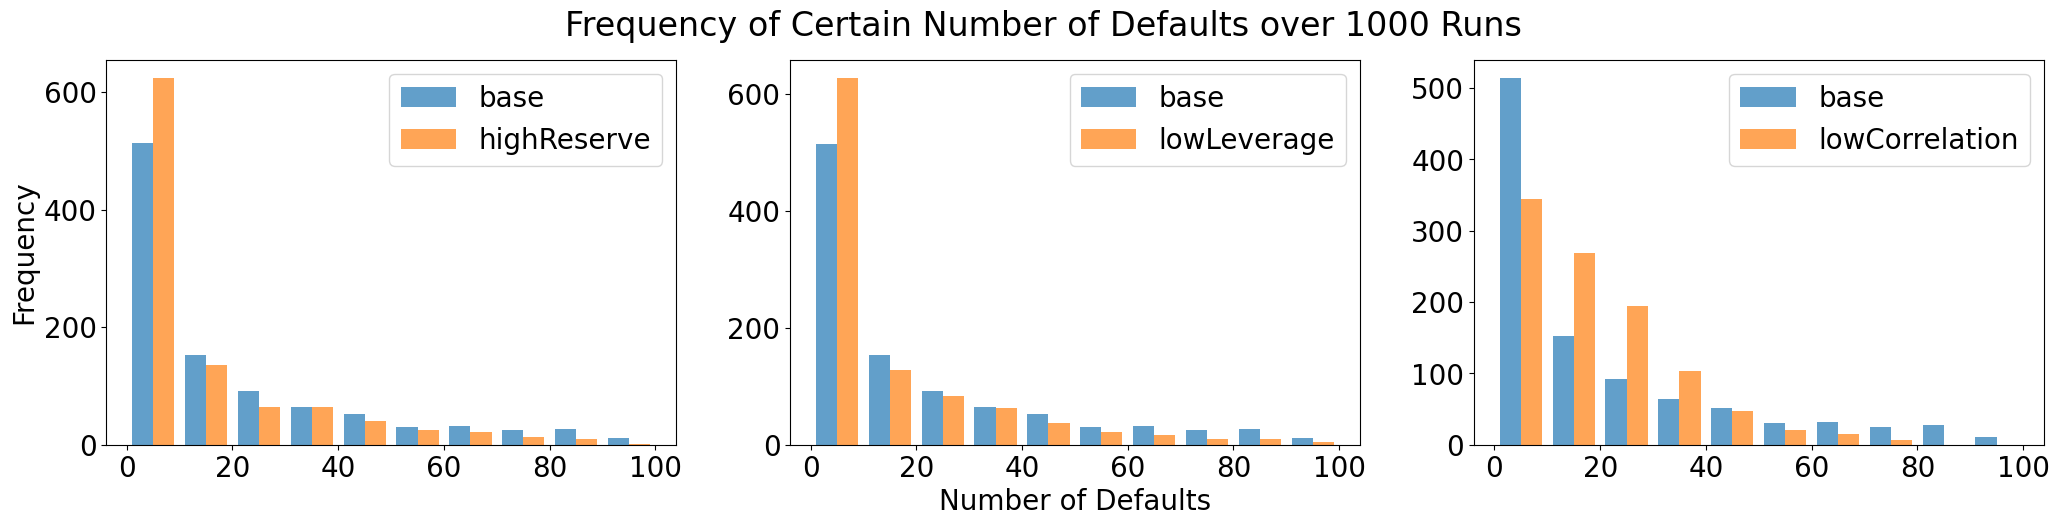

In [6]:
%pylab inline
import matplotlib.pyplot as plt
# create a 2 by 2 plot
pylab.rcParams['font.size'] = 20
fig, axs = plt.subplots(1, 3, figsize=(25,5))
fig.suptitle('Frequency of Certain Number of Defaults over 1000 Runs')
axs[0].hist([defaultCollection[0], defaultCollection[1]], bins = 10,label = ["base", "highReserve"],alpha=0.7)
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[1].hist([defaultCollection[0],defaultCollection[2]], bins = 10,label = ["base", "lowLeverage"], alpha=0.7)
axs[1].set_xlabel("Number of Defaults")
axs[1].legend()
axs[2].hist([defaultCollection[0],defaultCollection[3]], bins = 10,label = ["base", "lowCorrelation"], alpha=0.7)
axs[2].legend()